# Compare sorters with some dataset generated with MEArec

@author : Samuel Garcia

Alessio Paolo Buccino author of [MEArec](https://github.com/alejoe91/MEArec) have generated a dataset with ground truth. The simulated probe is **SqMEA-10-15**.

It is a very dense probe. The duration is 60s.

The file **recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13_31.h5** is (will be) freely downloadable to reproduce results.

This notebook is is demonstration of the spiketoolkit ground truth comparison framework.
It launch several popular sorter on this recording and compute some performence metrics.

The goal of this is **not** to rank sorter because some have then have certainly non optimal parameters for this particular dataset. The goal is to explore strength but mainly weekness of each sorters.



In [1]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spiketoolkit as st
import spikeextractors as se
from spiketoolkit.comparison import (setup_comparison_study, run_study_sorters,
            aggregate_sorting_comparison, aggregate_performances_table)

import MEAutility as mu
import MEArec as mr

# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]

15:43:27 [I] klustakwik KlustaKwik2 version 0.2.6
/home/samuel/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# p = '/media/samuel/SamCNRS/DataSpikeSorting/mearec/'
# p = '/home/samuel/DataSpikeSorting/mearec/'
p = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/mearec/'

study_folder = p + 'study_mearec'

mearec_filename = p + 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13_31.h5'

In [26]:
rec0  = se.MEArecRecordingExtractor(mearec_filename, locs_2d=False)
gt_sorting0 = se.MEArecSortingExtractor(mearec_filename)

# Inspect the dataset

Before, making the dataset lets explore probe geometry and grdound truth templates.

The signal are simulated using [MEArec](https://github.com/alejoe91/MEArec) written by Alessio Buccino.

 * It is a **very dense** probe using the shape **SqMEA-10-15**.
 * The probe have 10 X 10 channels.
 * There are **50** templates = **50** ground truth units.
 * As the array is dense, template have a high spatial definition and redundency.


MEAutility and MEArec offer easy to use plotting functions.

### Probe

In [27]:
# load the mearec file
recgen = mr.load_recordings(mearec_filename)

Text(0.5,1,'SqMEA-10-15um')

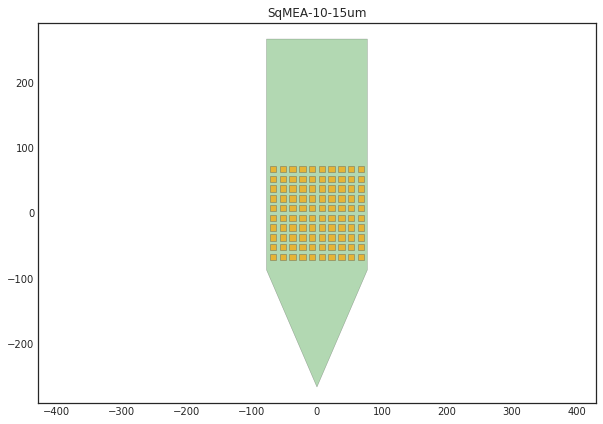

In [30]:
# plot the probe
probe_info = recgen.info['electrodes']
probe_name = recgen.info['electrodes']['electrode_name']
mea = mu.return_mea(info=probe_info)
fig, ax = plt.subplots()
mu.plot_probe(mea, ax=ax)
ax.set_title(probe_name)

### Some ground truth templates

Here a selection of 12 template out of 50.

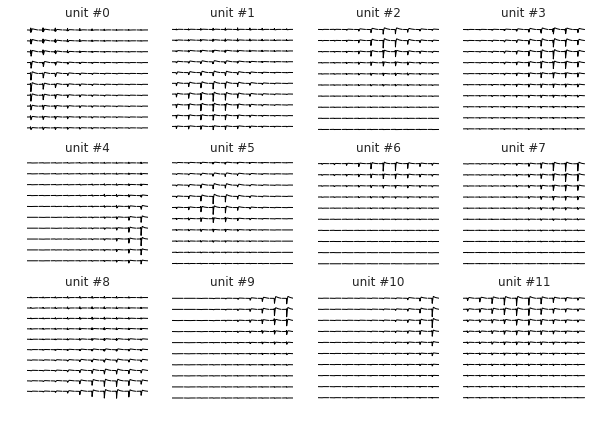

In [31]:
fig, axs = plt.subplots(nrows=3, ncols=4)
for i, unit_id in enumerate(gt_sorting0.get_unit_ids()[:12]):
    ax = axs.flatten()[i]
    mr.plot_templates(recgen, template_ids=unit_id, ax=ax)
    ax.set_title('unit #{}'.format(unit_id))

### Compute template SNR

Spiketookit have utilities to compute the peak of each template.
This is quite long so we save the results into a datataframe with xlsx format.

For the peak SNR is done as follow:
  * compute the median template with the ground truth indexes
  * detect where is the max channel.
  * get the peak amplitude
  * compute the MAD on the filtered signals on a fraction of the signal.
  * **snr = peak_amplitude / mad_of_the_channel**


On the following figures we can see that for the 500 units the SNR is between 3 and 19.

lets do the prediction that units with SNR  of 3 will be "hard" to detect and sort :).


In [37]:
snr = st.validation.compute_unit_SNR(rec0, gt_sorting0)
snr = pd.Series(snr, index=gt_sorting0.get_unit_ids())
snr.name = 'snr'
pd.DataFrame(snr).to_excel(p + 'units_snr.xlsx')

In [22]:
snr = pd.read_excel(p + 'units_snr.xlsx', index_col=0)['snr']

Text(0.5,0,'SNR of peak')

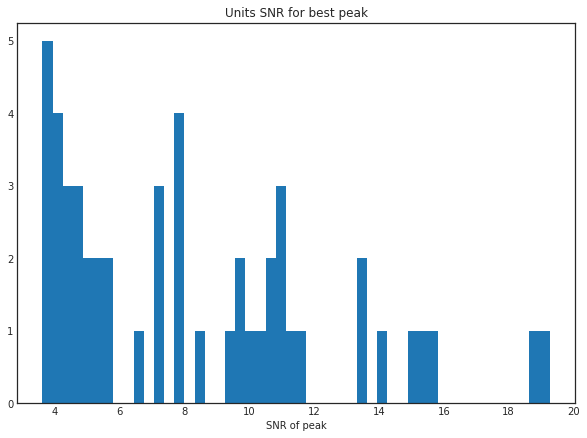

In [38]:
fig, ax = plt.subplots()
ax.hist(snr, bins=50)
ax.set_title('Units SNR for best peak')
ax.set_xlabel('SNR of peak')

## Step 1 : setup study folder

The function **setup_comparison_study** of spiketoolkit create a "study folder" with evrything copied inside.
The input is a dict of (recording + gt_sorting). Recording been the spikeextractor object representing traces and gt_sorting been the spikeextractor object representing the spike index of each units.


We need first to downloaded in the current directory.

Note: this file have a 3D geometry for teh probe. Many sorters work only with 2D.
So here we remove the first dimenssion of "location" in the recording.


In [ ]:

# this is a small trick to make the probe geometry planar.
for chan in rec0.get_channel_ids():
    loc = rec0.get_channel_property(chan, 'location')
    rec0.set_channel_property(chan, 'location', loc[1:])

gt_dict = {'rec0' : (rec0, gt_sorting0) }

setup_comparison_study(study_folder, gt_dict)


## Step 2 : run all sorter

This run all sorter on all recording and store the results in a working folder.

Note:s prevent 
  * of course this simple cells take hours to be computed. So when it is done never execute this again.
  * if a sorter is failing you can launch it again the 'keep' arg prevent recompute again.


In [5]:
# ironclust isleft because the wrapper is buggy and klusta do not scale correctly for 100 chans
sorter_list = ['tridesclous', 'herdingspikes', 'mountainsort4', 'spykingcircus', 'kilosort', 'kilosort2', 'klusta']
run_study_sorters(study_folder, sorter_list, mode='keep', engine='loop')

## Step3 : collect comparisons

spiketoolkit offer a GroundTruthComparison class that take a gt_sorting and a tested_sorting as input.
This class do:
  * match units between GT and tested
  * count FP/TP/FN/CL
  * compute the confusion matrix
  * make some performance table.

When we run a "study", the function **aggregate_sorting_comparison** collect of all **(rec_name, sorter_name)** pair and apply the GroundTruthComparison class for each.

So we have at once all comparison for all sorter for all recordings.
We can then exploit this to analyse results.

In [3]:
comparisons = aggregate_sorting_comparison(study_folder, exhaustive_gt=True)

## plot confusion matrix

The most important but quite verbose step to do is to look at confusion matrix between ground truth and sorter units:
  * The Y axis represent the GT units
  * the X axis represent the detected units.
  * each value of the matrix count how spike they have in common.
  * the bottom line is the FalsePositve FP spikes
  * the left columns is the FalseNegative FN spikes

Unfortunatly this big matrix are very diffuclt to inspect because we have to many  units.
By zooming then we can have a clear overviwe on the situation

Some rules to interpret this matrix:
  * square matrix with evry thing on the diagonal is the perfect situation.
  * vertical elongatated matrix means, but with a dialog in upper part is
    some units are detected some other no
  * horizontal elongated matrix means, the sorter detect too much units. More than the ground truth.
    wich is exhaustive here.
  * have a look on the FP line and FN columns.
  * spike out the diagonal is missclassification (CL)


See https://en.wikipedia.org/wiki/Confusion_matrix


rec0 tridesclous
rec0 kilosort
rec0 herdingspikes
rec0 spykingcircus


/home/samuel/Documents/projet/spikeinterface/spiketoolkit/spiketoolkit/comparison/comparisontools.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  fp = len(np.where(lab_st2 == 'FP')[0])


rec0 klusta
rec0 kilosort2


/home/samuel/.virtualenvs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


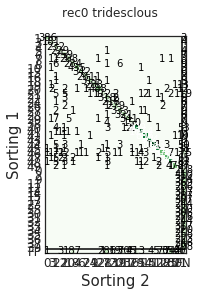

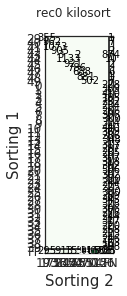

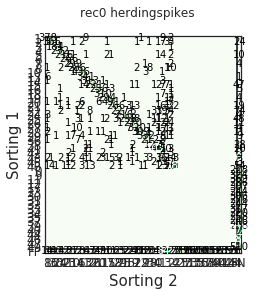

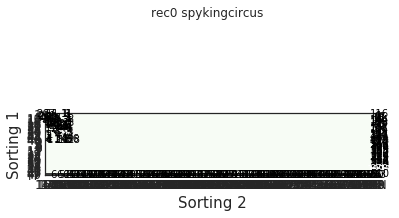

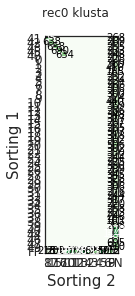

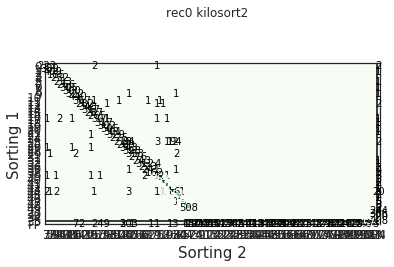

In [4]:
for (rec_name, sorter_name), comp in comparisons.items():
    print(rec_name, sorter_name)
    fig, ax = plt.subplots()
    comp.plot_confusion_matrix(ax=ax)
    fig.suptitle(rec_name + ' ' + sorter_name)

## print summary and average perf


To summary performence each GroundTruthComparison can print performance and a summary.


In [1]:
for (rec_name, sorter_name), comp in comparisons.items():
    print('*'*40)
    print(rec_name, sorter_name)
    print('*'*40)
    comp.print_summary()
    comp.print_performance('pooled_with_average')

NameError: name 'comparisons' is not defined

## Step 4 : collect tables

spiketoolkit propos ethe function **aggregate_performances_table** to concatenate several table of performance.


**dataframes** is a dict that contain several results formated in dataframes:
  * run_times : time for computing each one
  * perf_pooled_with_sum: performance with method **pooled_with_sum**
  * perf_pooled_with_average: performance with method **pooled_with_average**
  * nb_units_above_threshold: count how many units detect with a treshold on a perf columns.
  * perf_by_spiketrain: the most convinient one perf at units level

In [6]:
%%capture --no-display
dataframes = aggregate_performances_table(study_folder, exhaustive_gt=True)

In [7]:
dataframes['perf_pooled_with_sum']

accuracy    recall precision false_discovery_rate  \
rec_name sorter_name                                                        
rec0     tridesclous    0.658647  0.697254  0.922454            0.0775463   
         kilosort       0.366699  0.396828   0.82847              0.17153   
         herdingspikes  0.506712  0.544028  0.880774             0.119226   
         spykingcircus   0.33921  0.340132  0.992068           0.00793201   
         klusta         0.161992  0.165291  0.890304             0.109696   
         kilosort2      0.922512  0.947002  0.972731            0.0272686   

                        miss_rate misclassification_rate  
rec_name sorter_name                                      
rec0     tridesclous     0.300613             0.00704599  
         kilosort         0.60195             0.00202693  
         herdingspikes   0.447324              0.0189663  
         spykingcircus    0.65576             0.00622557  
         klusta          0.834709                      0  
         kilosort2      0.0526036             0.00743207

In [8]:
dataframes['perf_pooled_with_average']

accuracy     recall precision false_discovery_rate  \
rec_name sorter_name                                                          
rec0     tridesclous     0.557193   0.590798  0.940635            0.0593648   
         kilosort        0.179379   0.199066  0.818532             0.181468   
         herdingspikes   0.536666   0.576064  0.897008             0.102992   
         spykingcircus   0.314492   0.315895  0.991791           0.00820865   
         klusta         0.0676095  0.0728147  0.909024            0.0909763   
         kilosort2       0.897439   0.917387  0.978227            0.0217732   

                        miss_rate misclassification_rate  
rec_name sorter_name                                      
rec0     tridesclous     0.408546             0.00597257  
         kilosort        0.800078            0.000942938  
         herdingspikes    0.42142              0.0198142  
         spykingcircus   0.682318             0.00540255  
         klusta          0.927185                      0  
         kilosort2      0.0825369             0.00895285

In [9]:
dataframes['count_units']

num_gt  num_sorter  num_well_detected  num_redundant  \
rec_name sorter_name                                                           
rec0     tridesclous      50.0        32.0               19.0            0.0   
         kilosort         50.0        15.0                7.0            3.0   
         herdingspikes    50.0        45.0               12.0            6.0   
         spykingcircus    50.0       274.0                2.0           20.0   
         klusta           50.0        16.0                0.0            6.0   
         kilosort2        50.0       105.0               43.0            3.0   

                        num_false_positive  num_bad  
rec_name sorter_name                                 
rec0     tridesclous                   0.0      1.0  
         kilosort                      0.0      4.0  
         herdingspikes                 0.0     14.0  
         spykingcircus                62.0    252.0  
         klusta                        0.0     11.0  
         kilosort2                     2.0     59.0

## Step 5: inspect result by spiketrain

For finer exploration, we can also retrieve for all **(rec_name, sorter_name)** pair the raw count unit by unit for each sorter.

This give a give result for each units of the ground truth.

In [10]:
for (rec_name, sorter_name), comp in comparisons.items():
    print(rec_name, sorter_name)
    perf = comp.get_performance(method='raw_count')
    display(perf)

rec0 tridesclous


,tp,fn,cl,fp,num_gt,num_tested,tested_id
gt_unit_id,,,,,,,
0,0,228,0,0,228,0,-1
1,386,3,0,1,389,387,0
2,0,410,0,0,410,0,-1
3,181,4,0,0,185,186,3
4,232,0,0,0,232,232,1
5,229,4,1,3,234,234,22
6,259,7,0,0,266,259,2
7,298,3,5,0,306,303,10
8,284,9,7,187,300,474,18


rec0 kilosort


,tp,fn,cl,fp,num_gt,num_tested,tested_id
gt_unit_id,,,,,,,
0,0,228,0,0,228,0,-1
1,0,389,0,0,389,0,-1
2,0,410,0,0,410,0,-1
3,0,185,0,0,185,0,-1
4,0,232,0,0,232,0,-1
5,0,234,0,0,234,0,-1
6,0,266,0,0,266,0,-1
7,0,306,0,0,306,0,-1
8,0,300,0,0,300,0,-1


rec0 herdingspikes


,tp,fn,cl,fp,num_gt,num_tested,tested_id
gt_unit_id,,,,,,,
0,0,228,0,0,228,0,-1
1,378,0,11,14,389,404,8
2,366,24,20,18,410,388,16
3,184,0,1,40,185,227,30
4,232,0,0,3,232,237,24
5,216,10,8,42,234,258,32
6,266,0,0,8,266,274,23
7,299,4,3,27,306,335,10
8,286,0,14,12,300,317,14


rec0 spykingcircus


,tp,fn,cl,fp,num_gt,num_tested,tested_id
gt_unit_id,,,,,,,
0,0,228,0,0,228,0,-1
1,267,116,6,0,389,267,146
2,0,410,0,0,410,0,-1
3,0,185,0,0,185,0,-1
4,231,1,0,0,232,231,167
5,165,67,2,0,234,165,14
6,0,266,0,0,266,0,-1
7,0,306,0,0,306,0,-1
8,0,300,0,0,300,0,-1


rec0 klusta


,tp,fn,cl,fp,num_gt,num_tested,tested_id
gt_unit_id,,,,,,,
0,0,228,0,0,228,0,-1
1,0,389,0,0,389,0,-1
2,0,410,0,0,410,0,-1
3,0,185,0,0,185,0,-1
4,0,232,0,0,232,0,-1
5,0,234,0,0,234,0,-1
6,0,266,0,0,266,0,-1
7,0,306,0,0,306,0,-1
8,0,300,0,0,300,0,-1


rec0 kilosort2


,tp,fn,cl,fp,num_gt,num_tested,tested_id
gt_unit_id,,,,,,,
0,223,2,3,0,228,223,7
1,389,0,0,0,389,389,38
2,409,1,0,0,410,409,58
3,185,0,0,0,185,185,78
4,232,0,0,0,232,232,94
5,233,1,0,0,234,233,40
6,266,0,0,0,266,266,60
7,305,1,0,0,306,305,80
8,300,0,0,0,300,300,75


In [11]:
for (rec_name, sorter_name), comp in comparisons.items():
    print(rec_name, sorter_name)
    perf = comp.get_performance(method='by_spiketrain')
    display(perf)

rec0 tridesclous


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
gt_unit_id,,,,,,
0,0.000000,0.000000,NaN,NaN,1.000000,0.000000
1,0.989744,0.992288,0.997416,0.002584,0.007712,0.000000
2,0.000000,0.000000,NaN,NaN,1.000000,0.000000
3,0.978378,0.978378,1.000000,0.000000,0.021622,0.000000
4,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
5,0.970339,0.982833,0.987069,0.012931,0.017094,0.004274
6,0.973684,0.973684,1.000000,0.000000,0.026316,0.000000
7,0.990033,0.990033,1.000000,0.000000,0.009804,0.016340
8,0.591667,0.969283,0.602972,0.397028,0.030000,0.023333


rec0 kilosort


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
gt_unit_id,,,,,,
0,0.000000,0.000000,NaN,NaN,1.000000,0.000000
1,0.000000,0.000000,NaN,NaN,1.000000,0.000000
2,0.000000,0.000000,NaN,NaN,1.000000,0.000000
3,0.000000,0.000000,NaN,NaN,1.000000,0.000000
4,0.000000,0.000000,NaN,NaN,1.000000,0.000000
5,0.000000,0.000000,NaN,NaN,1.000000,0.000000
6,0.000000,0.000000,NaN,NaN,1.000000,0.000000
7,0.000000,0.000000,NaN,NaN,1.000000,0.000000
8,0.000000,0.000000,NaN,NaN,1.000000,0.000000


rec0 herdingspikes


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
gt_unit_id,,,,,,
0,0.000000,0.000000,NaN,NaN,1.000000,0.000000
1,0.964286,1.000000,0.964286,0.035714,0.000000,0.028278
2,0.897059,0.938462,0.953125,0.046875,0.058537,0.048780
3,0.821429,1.000000,0.821429,0.178571,0.000000,0.005405
4,0.987234,1.000000,0.987234,0.012766,0.000000,0.000000
5,0.805970,0.955752,0.837209,0.162791,0.042735,0.034188
6,0.970803,1.000000,0.970803,0.029197,0.000000,0.000000
7,0.906061,0.986799,0.917178,0.082822,0.013072,0.009804
8,0.959732,1.000000,0.959732,0.040268,0.000000,0.046667


rec0 spykingcircus


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
gt_unit_id,,,,,,
0,0.000000,0.000000,NaN,NaN,1.000000,0.000000
1,0.697128,0.697128,1.000000,0.000000,0.298201,0.015424
2,0.000000,0.000000,NaN,NaN,1.000000,0.000000
3,0.000000,0.000000,NaN,NaN,1.000000,0.000000
4,0.995690,0.995690,1.000000,0.000000,0.004310,0.000000
5,0.711207,0.711207,1.000000,0.000000,0.286325,0.008547
6,0.000000,0.000000,NaN,NaN,1.000000,0.000000
7,0.000000,0.000000,NaN,NaN,1.000000,0.000000
8,0.000000,0.000000,NaN,NaN,1.000000,0.000000


rec0 klusta


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
gt_unit_id,,,,,,
0,0.000000,0.000000,NaN,NaN,1.000000,0.0
1,0.000000,0.000000,NaN,NaN,1.000000,0.0
2,0.000000,0.000000,NaN,NaN,1.000000,0.0
3,0.000000,0.000000,NaN,NaN,1.000000,0.0
4,0.000000,0.000000,NaN,NaN,1.000000,0.0
5,0.000000,0.000000,NaN,NaN,1.000000,0.0
6,0.000000,0.000000,NaN,NaN,1.000000,0.0
7,0.000000,0.000000,NaN,NaN,1.000000,0.0
8,0.000000,0.000000,NaN,NaN,1.000000,0.0


rec0 kilosort2


,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
gt_unit_id,,,,,,
0,0.991111,0.991111,1.000000,0.000000,0.008772,0.013158
1,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
2,0.997561,0.997561,1.000000,0.000000,0.002439,0.000000
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
4,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
5,0.995726,0.995726,1.000000,0.000000,0.004274,0.000000
6,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
7,0.996732,0.996732,1.000000,0.000000,0.003268,0.000000
8,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000


## Step 6 : easy plot with seaborn

With the seaborn package, it is very easy to summary with plot dataframes.

Here some basic example for performances and run times.

### Run times

Run times is not plotted here because it has been lauch on several machine.

In [ ]:
run_times = dataframes['run_times'].reset_index()
fig, ax = plt.subplots()
sns.barplot(data=run_times, x='rec_name', y='run_time', hue='sorter_name', ax=ax)
ax.set_title('Run times (s)')

### By spiketrain

The more convinient dataframes is **'perf_by_spiketrain'**.

Here we plot for each sorter the accuracy for each units in the ground truth.

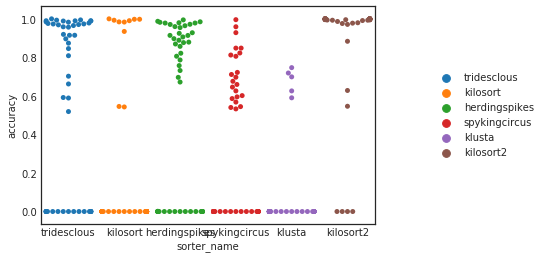

In [17]:
perfs = dataframes['perf_by_spiketrain'].reset_index()
fig, ax = plt.subplots()
g = sns.swarmplot(data=perfs, x='sorter_name', y='accuracy', hue='sorter_name', ax=ax)
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

### Accuracy sum

Here is the plot of the accuracy with the **sum** method for pooling results.

(0, 1)

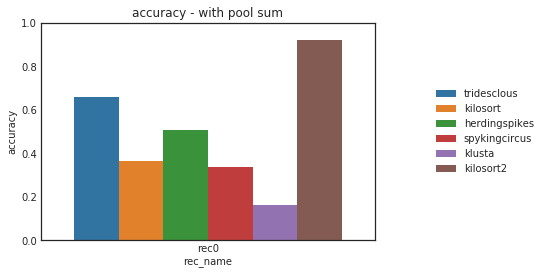

In [18]:
perfs = dataframes['perf_pooled_with_sum'].reset_index()
fig, ax = plt.subplots()
g = sns.barplot(data=perfs, x='rec_name', y='accuracy', hue='sorter_name', ax=ax)
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax.set_title('accuracy - with pool sum')
ax.set_ylim(0, 1)

### Accuracy average

Here is the plot of the accuracy with the **sum** method for pooling results.

(0, 1)

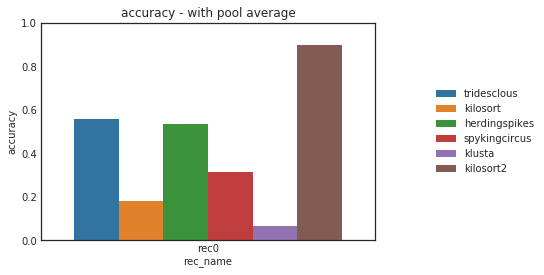

In [19]:
perfs = dataframes['perf_pooled_with_average'].reset_index()
fig, ax = plt.subplots()
g = sns.barplot(data=perfs, x='rec_name', y='accuracy', hue='sorter_name', ax=ax)
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax.set_title('accuracy - with pool average')
ax.set_ylim(0, 1)

### accuracy vs SNR

Here a plot to see if the high SNR make better accuracy.

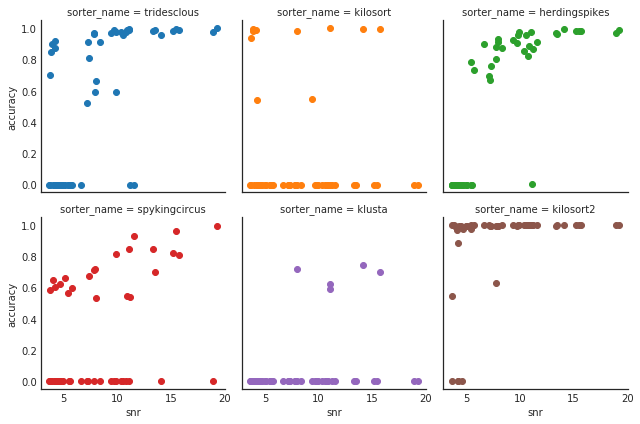

In [23]:
# insert snr columns
perfs = dataframes['perf_by_spiketrain'].reset_index()
perfs['snr'] = perfs['gt_unit_id'].apply(lambda id: snr.loc[id])

grid = sns.FacetGrid(perfs, hue='sorter_name', col='sorter_name', col_wrap=3)
grid.map(plt.plot, 'snr', 'accuracy', marker="o", ls='None')


### How many units detected above threshold

The very end question for an experimentalist using software for spike sorting would be, how many cells is it able to detect correctly ?
One anwser could be cells with accuracy above a threshold.

For instance here we count how many cells above 0.95 the sorter is able to detect.

The max is 50 cells.

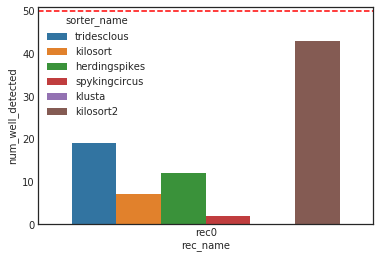

In [24]:
perfs = dataframes['count_units'].reset_index()

fig, ax = plt.subplots()
ax = sns.barplot(data=perfs, x='rec_name', y='num_well_detected', hue='sorter_name', ax=ax)
ax.set_ylim(0, 51)
ax.axhline(50, ls='--', color='red')

### How many units should not be detected at all

Here we count "bad_units" meaning how many units detected to not match any units in the GT.

here clearly all sorter using template matching have problems of over detecting.

**bad_units** can be split in 2 category:
  * false positive units
  * redundant detection (units is detected twice or more)

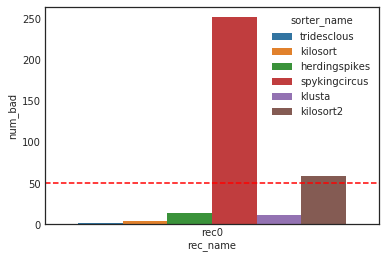

In [25]:
perfs = dataframes['count_units'].reset_index()

fig, ax = plt.subplots()
ax = sns.barplot(data=perfs, x='rec_name', y='num_bad', hue='sorter_name', ax=ax)
ax.axhline(50, ls='--', color='red')

## False positive units

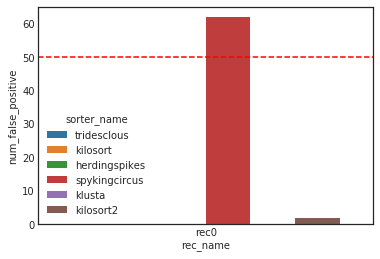

In [26]:
perfs = dataframes['count_units'].reset_index()

fig, ax = plt.subplots()
ax = sns.barplot(data=perfs, x='rec_name', y='num_false_positive', hue='sorter_name', ax=ax)
ax.axhline(50, ls='--', color='red')

## redundant detection

Here we count how many units are detected twice or more.

Here again sorter based on template matching have a weakness they produce to much units.

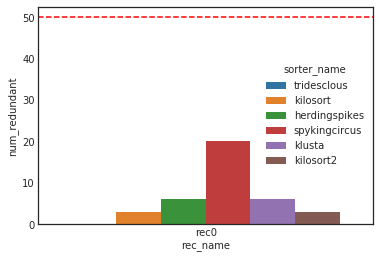

In [27]:
perfs = dataframes['count_units'].reset_index()

fig, ax = plt.subplots()
ax = sns.barplot(data=perfs, x='rec_name', y='num_redundant', hue='sorter_name', ax=ax)
ax.axhline(50, ls='--', color='red')

# Conlusion

Comparing sorter is not trivial at all.
Counting true positive spike is not enough.
We also take in account at units level :
  * FN with recall
  * FP with precision
  * FN and FP with accuracy
  * CL msiclaification
 
But we also need to look at:
  * fakse positive units
  * redundant detection

